### Metrics 3 Supplement - replicating metric calcs
**answer:** the problem was using pred instead actual in the folloing formula :

    baseline = ((actual - actual.mean(0))**2).sum(1)**0.5
    
**original question (now answered):** Why does resnet-topleft have negative dist_r2?

In [1]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from fastai2.basics import *
from fastai2.vision.all import *
%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet
from module.mnist_metrics import metrics_df

#### Load + Eval Models

In [2]:
dls_tl = build_dls(target='topleft')
dls_cr = build_dls(target='center')

In [3]:
!ls models

cloud_center.pth  pt3_center_2.pth  pt3_topleft_1.pth  reg_multi_sc_50.pth
ft-4b.pth	  pt3_center_3.pth  pt3_topleft_2.pth
pt3_both_1.pth	  pt3_center_4.pth  reg_multi_50.pth


In [4]:
model_fn   = 'pt3_topleft_2'

learn = cnn_learner(dls_tl, 
                    resnet18, 
                    y_range=(-1.,1.),
                   )

learn.load(model_fn)

In [5]:
df_tl = metrics_df(learn, 'ResNet18', '90 fit epochs', 'topleft')
df_tl['target'] = 'topleft'
df_tl

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,ResNet18,90 fit epochs,topleft,valid,0.021076,0.094615,0.441618,0.159876,-0.166417,0.042151,-0.593328
1,ResNet18,90 fit epochs,topleft,train,0.006929,0.047295,0.696516,0.073935,0.649399,0.013857,0.800065


#### Weird Result
MSE-model < MSE-baseline, but...

Dist-model < Dist-baseline

Is this because different amount of variation in X and Y coords? Maybe.

Is this because dist takes square root?

In [23]:
preds = learn.get_preds(ds_idx=1)

In [24]:
pred = preds[0]
actual = preds[1].squeeze(1)

dist     = ((pred - actual)**2).sum(1)**0.5
baseline = ((pred - actual.mean(0))**2).sum(1)**0.5
dist.mean(), baseline.mean()

(tensor(0.1599), tensor(0.1371))

In [27]:
# sqdist_r2 displays same pattern
dist_sq     = ((pred - actual)**2).sum(1)
baseline_sq = ((pred - actual.mean(0))**2).sum(1)
dist_sq.mean(), baseline_sq.mean()

(tensor(0.0422), tensor(0.0265))

Indeed, the mean distance error is above the mean baseline error, so it's correct that dist_r2 is negative. Why is that?

In [29]:
mse(actual, pred)

tensor(0.0211)

In [28]:
ybar = torch.ones_like(actual) * actual.mean(0)
mse(actual, ybar)

tensor(0.0320)

Indeed MSE (which is the average of sq-err for each coord) is lower for the model than baseline, so it is correct that normal mse/ normal r2 is positive.

In [30]:
mse(pred[:,0], actual[:,0]), mse(pred[:,1], actual[:,1])

(tensor(0.0385), tensor(0.0036))

In [31]:
# match model mse calc
(0.0385 + 0.0036) / 2

0.02105

In [32]:
((actual[:,0] - actual[:,0].mean(0))**2).mean(), \
((actual[:,1] - actual[:,1].mean(0))**2).mean()

(tensor(0.0553), tensor(0.0087))

In [33]:
# match baseline mse calc
(0.0553 + 0.0087) / 2

0.032

In [34]:
diff_model = pred - actual
diff_base  = actual.mean(0) - actual

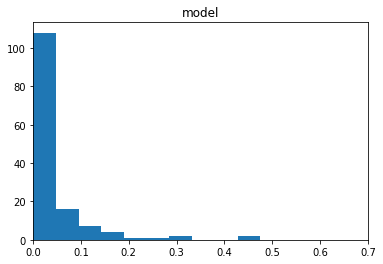

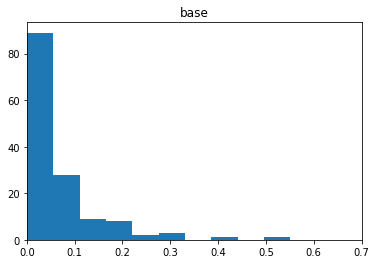

In [40]:
plt.hist((diff_model**2).sum(1)); plt.title('model')
plt.xlim(0,0.7);plt.show()
plt.hist((diff_base**2).sum(1)); plt.title('base')
plt.xlim(0,0.7);plt.show()

In [ ]:
plt.hist(diff_base)

#### Plots

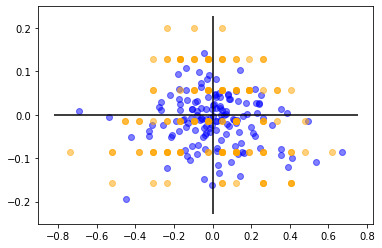

In [22]:
diff_model = pred - actual
diff_base  = actual.mean(0) - actual
plt.scatter(diff_model[:,0], diff_model[:,1], c='blue', alpha=0.5)
plt.scatter(diff_base[:,0], diff_base[:,1], c= 'orange', alpha=0.5)
xlo, xhi = plt.xlim()
ylo, yhi = plt.ylim()
plt.hlines(0, xlo, xhi);
plt.vlines(0, ylo, yhi);

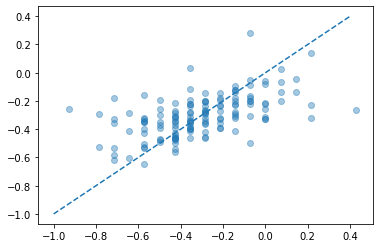

In [71]:
plt.scatter(actual[:,0], pred[:,0], alpha=0.4)
plt.plot([-1, 0.4], [-1, 0.4], linestyle= '--');

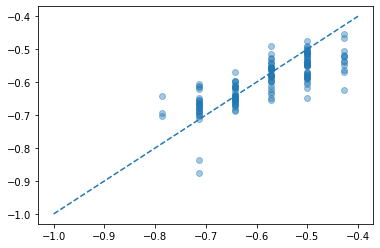

In [72]:
plt.scatter(actual[:,1], pred[:,1], alpha=0.4)
plt.plot([-1, -0.4], [-1, -0.4], linestyle= '--');